In [1]:
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns

%config InlineBackend.figure_format = 'png'
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

In [2]:
random.seed(50)

#### Get thermal gens Boolean index

In [3]:
# Time steps
nt = 12

# All buses
num_buses = 118
buses = np.arange(1, num_buses+1)

# Read thermal buses
file_path = '../../data/IEEE_Case118/zones/thermal_bus.csv'
thermal_buses = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
# Read load buses
file_path = '../../data/IEEE_Case118/zones/load_bus.csv'
load_buses = pd.read_csv(file_path, header=None, index_col=None).to_numpy()

# Get thermal buses Boolean index
thermal_bidx = np.isin(buses, thermal_buses)
# Get load buses Boolean index
load_bidx = np.isin(buses, load_buses)

#### Thermal PG prediction analysis

##### Plot PG ground true and prediction for demonstration

In [4]:
# The number of demonstration plots
num_demos = 10

for i in range(num_demos):
    # Read PG true
    file_path = f'./model_evaluation/PG_true/true_{i+1}.csv'
    PG_true = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    PG_true = PG_true[thermal_bidx, :nt]

    # Read PG prediction
    file_path = f'./model_evaluation/PG_pred/pred_{i+1}.csv'
    PG_pred= pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    PG_pred = PG_pred[thermal_bidx, :nt]

    # Calculate relative error
    rela_err = np.zeros(PG_true.shape)
    indices = np.where(PG_true!=0)
    rela_err[indices] = np.abs((PG_true[indices] - PG_pred[indices]) / PG_true[indices]) * 100
    indices = np.where((PG_true == 0) & (PG_pred == 0))
    rela_err[indices] = 0.
    indices = np.where((PG_true == 0) & (PG_pred != 0))
    rela_err[indices] = np.NaN
    
    fig = plt.figure(figsize=(9, 4))
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.set_title('Ground truth (MW)')
    ax2 = fig.add_subplot(1, 3, 2)
    ax2.set_title('Prediction (MW)')
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.set_title('Relative error (%)')

    sns.heatmap(PG_true, 
                ax=ax1,  
                vmin=0,
                xticklabels=[], 
                yticklabels=[],
                linewidth=0.01)
    sns.heatmap(PG_pred, 
                ax=ax2, 
                vmin=0,
                xticklabels=[], 
                yticklabels=[],
                linewidth=0.01)
    sns.heatmap(rela_err,
                ax=ax3,
                vmin=0,
                xticklabels=[],
                yticklabels=[],
                linewidth=0.01)
    plt.tight_layout()
    fig.savefig(f'./model_evaluation/PG_plotting/fig{i+1}.pdf')
    plt.close('all')

##### Calculate MRE (cases where *PG_true==0 & PG_pred!=0* are not considered)

In [4]:
# Overall number of PG
num_data = 2000

# Record relative error
rela_err = np.zeros((num_data, thermal_bidx.sum(), nt))

for i in range(num_data):
    # Read PG true
    file_path = f'./model_evaluation/PG_true/true_{i+1}.csv'
    PG_true = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    PG_true = PG_true[thermal_bidx, :nt]

    # Read PG prediction
    file_path = f'./model_evaluation/PG_pred/pred_{i+1}.csv'
    PG_pred = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    PG_pred = PG_pred[thermal_bidx, :nt]

    # Calculate relative error
    indices = np.where(PG_true!=0) 
    rela_err[i][indices] = np.abs((PG_true[indices] - PG_pred[indices]) / PG_true[indices]) * 100

    indices = np.where((PG_true == 0) & (PG_pred == 0))
    rela_err[i][indices] = 0.

    indices = np.where((PG_true == 0) & (PG_pred != 0))
    rela_err[i][indices] = np.NaN

In [5]:
# Don't count the case where the relative error is inf
mre = np.nanmean(rela_err, axis=0)

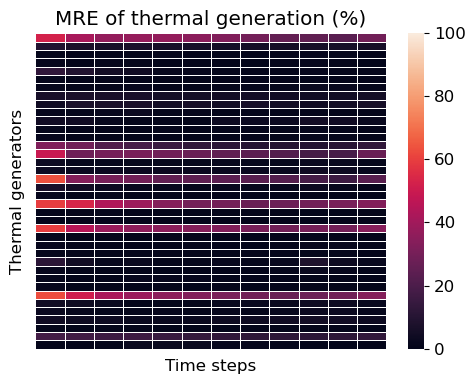

In [7]:
# Plot mean relative error
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111)
sns.heatmap(mre, 
            ax=ax,
            vmin=0,
            vmax=100,
            xticklabels=[],
            yticklabels=[],
            linewidth=0.5)
ax.set_title('MRE of thermal generation (%)')
ax.set_xlabel('Time steps')
ax.set_ylabel('Thermal generators')
plt.tight_layout()
plt.show()
plt.close('all')

##### Calculate MRE of zonal aggregated PG

In [6]:
# Buses in each zone
file_path = '../../data/IEEE_Case118/zones/zone1_bus.csv'
zone1_buses = pd.read_csv(file_path, header=None, index_col=None).to_numpy()

file_path = '../../data/IEEE_Case118/zones/zone2_bus.csv'
zone2_buses = pd.read_csv(file_path, header=None, index_col=None).to_numpy()

file_path = '../../data/IEEE_Case118/zones/zone3_bus.csv'
zone3_buses = pd.read_csv(file_path, header=None, index_col=None).to_numpy()

# Thermal bidx in each zone
thermal_bidx_zone1 = np.isin(thermal_buses, zone1_buses).flatten()
thermal_bidx_zone2 = np.isin(thermal_buses, zone2_buses).flatten()
thermal_bidx_zone3 = np.isin(thermal_buses, zone3_buses).flatten()

In [7]:
# Number of zones
num_zones = 3

# PG sum
PG_sum_true = np.zeros((num_data, num_zones+1, nt))
PG_sum_pred = np.zeros((num_data, num_zones+1, nt))

for i in range(num_data):
    # Read PG true
    file_path = f'./model_evaluation/PG_true/true_{i+1}.csv'
    PG_true = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    PG_true = PG_true[thermal_bidx, :nt]
    temp0 = PG_true[thermal_bidx_zone1].sum(axis=0)
    temp1 = PG_true[thermal_bidx_zone2].sum(axis=0)
    temp2 = PG_true[thermal_bidx_zone3].sum(axis=0)
    temp3 = PG_true.sum(axis=0)
    PG_sum_true[i, 0] = temp0.copy()
    PG_sum_true[i, 1] = temp1.copy()
    PG_sum_true[i, 2] = temp2.copy()
    PG_sum_true[i, 3] = temp3.copy()

    # Read PG prediction
    file_path = f'./model_evaluation/PG_pred/pred_{i+1}.csv'
    PG_pred = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    PG_pred = PG_pred[thermal_bidx, :nt]
    temp0 = PG_pred[thermal_bidx_zone1].sum(axis=0)
    temp1 = PG_pred[thermal_bidx_zone2].sum(axis=0)
    temp2 = PG_pred[thermal_bidx_zone3].sum(axis=0)
    temp3 = PG_pred.sum(axis=0)
    PG_sum_pred[i, 0] = temp0.copy()
    PG_sum_pred[i, 1] = temp1.copy()
    PG_sum_pred[i, 2] = temp2.copy()
    PG_sum_pred[i, 3] = temp3.copy()

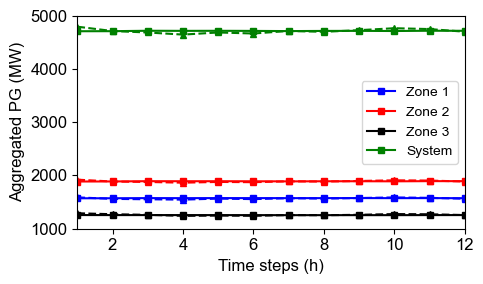

In [92]:
# Plot mean zonal aggregated PG
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
# Zone 1 aggregated PG
ax.plot(np.arange(12)+1, PG_sum_true.mean(axis=0)[0], color='blue', marker='s', markersize=5, label='Zone 1')
ax.plot(np.arange(12)+1, PG_sum_pred.mean(axis=0)[0], linestyle='dashed', color='blue', marker='^', markersize=5)

# Zone 1 aggregated PG
ax.plot(np.arange(12)+1, PG_sum_true.mean(axis=0)[1], color='red', marker='s', markersize=5, label='Zone 2')
ax.plot(np.arange(12)+1, PG_sum_pred.mean(axis=0)[1], linestyle='dashed', color='red', marker='^', markersize=5)

# Zone 1 aggregated PG
ax.plot(np.arange(12)+1, PG_sum_true.mean(axis=0)[2], color='black', marker='s', markersize=5, label='Zone 3')
ax.plot(np.arange(12)+1, PG_sum_pred.mean(axis=0)[2], linestyle='dashed', color='black', marker='^', markersize=5)

# System aggregated PG
ax.plot(np.arange(12)+1, PG_sum_true.mean(axis=0)[3], color='green', marker='s', markersize=5, label='System')
ax.plot(np.arange(12)+1, PG_sum_pred.mean(axis=0)[3], linestyle='dashed', color='green', marker='^', markersize=5)

ax.set_xlim((1, 12))
ax.set_ylim((1e3, 5e3))
ax.set_xlabel('Time steps (h)')
ax.set_ylabel('Aggregated PG (MW)')
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()
plt.close('all')

In [8]:
rela_err = np.abs((PG_sum_true - PG_sum_pred) / PG_sum_true) * 100

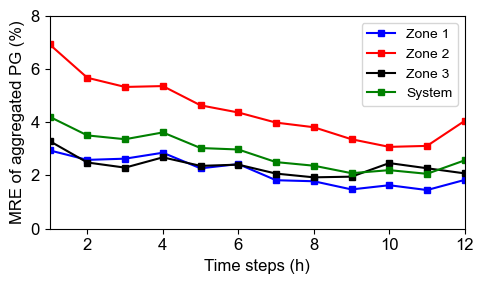

In [10]:
# Plot mean zonal aggregated PG relative error
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
# Zone 1 aggregated PG
ax.plot(np.arange(12)+1, rela_err.mean(axis=0)[0], color='blue', marker='s', markersize=5, label='Zone 1')

# Zone 1 aggregated PG
ax.plot(np.arange(12)+1, rela_err.mean(axis=0)[1], color='red', marker='s', markersize=5, label='Zone 2')

# Zone 1 aggregated PG
ax.plot(np.arange(12)+1, rela_err.mean(axis=0)[2], color='black', marker='s', markersize=5, label='Zone 3')

# System aggregated PG
ax.plot(np.arange(12)+1, rela_err.mean(axis=0)[3], color='green', marker='s', markersize=5, label='System')

ax.set_xlim((1, 12))
ax.set_ylim((0, 8))
ax.set_xlabel('Time steps (h)')
ax.set_ylabel('MRE of aggregated PG (%)')
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()
plt.close('all')

##### Calculate load shedding

In [21]:
from torch_geometric.loader import DataLoader
from MyDataset import MyDataset

# Root
root = '../../train_val_test_dataset/IEEE_Case118/PG'

# Load all data with empty input
dataset = MyDataset(root=root, data_list=[])

# Get train dataset
test_size = 2000

test_dataset = dataset[-test_size:]

# Create train loader
############ Shuffle cannot be true for testing data ##############
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [47]:
# Load bidx in each zone
load_bidx_zone1 = np.isin(load_buses, zone1_buses).flatten()
load_bidx_zone2 = np.isin(load_buses, zone2_buses).flatten()
load_bidx_zone3 = np.isin(load_buses, zone3_buses).flatten()

In [50]:
# Get load inputs
load_input = np.zeros((num_data, num_zones+1, nt))

for i, loader in enumerate(test_loader):
    # Get load input of individual graph
    temp = loader.x.detach().numpy()[load_bidx, -2*nt:-nt]
    load_input[i, 0] = temp[load_bidx_zone1].sum(axis=0)
    load_input[i, 1] = temp[load_bidx_zone2].sum(axis=0)
    load_input[i, 2] = temp[load_bidx_zone3].sum(axis=0)
    load_input[i, 3] = temp.sum(axis=0)


# Read deployed load
deployed_load_true = np.zeros((num_data, num_zones+1, nt))
deployed_load_pred = np.zeros((num_data, num_zones+1, nt))

for i in range(num_data):
    # Read ground truth
    file_path = f'model_evaluation/PG_true/true_{i+1}.csv'
    load_true = pd.read_csv(file_path, header=None, index_col=None).to_numpy()[load_bidx, -nt:]
    deployed_load_true[i, 0] = load_true[load_bidx_zone1].sum(axis=0)
    deployed_load_true[i, 1] = load_true[load_bidx_zone2].sum(axis=0)
    deployed_load_true[i, 2] = load_true[load_bidx_zone3].sum(axis=0)
    deployed_load_true[i, 3] = load_true.sum(axis=0)

    # Read prediction
    file_path = f'model_evaluation/PG_pred/pred_{i+1}.csv'
    load_pred = pd.read_csv(file_path, header=None, index_col=None).to_numpy()[load_bidx, -nt:]
    deployed_load_pred[i, 0] = load_pred[load_bidx_zone1].sum(axis=0)
    deployed_load_pred[i, 1] = load_pred[load_bidx_zone2].sum(axis=0)
    deployed_load_pred[i, 2] = load_pred[load_bidx_zone3].sum(axis=0)
    deployed_load_pred[i, 3] = load_pred.sum(axis=0)

In [102]:
# Calculate shedding
shedding_true = load_input - deployed_load_true
shedding_pred = load_input - deployed_load_pred

shedding_rela_err = np.zeros(shedding_true.shape)

# Set relative error = NaN for zero ground truth
indices = np.where(np.abs(shedding_true) <= 500)
shedding_rela_err[indices] = np.NaN

# Calculate relative error for nonzero ground truth
indices = np.where(np.abs(shedding_true) > 500)
shedding_rela_err[indices] = np.abs((shedding_true[indices] - shedding_pred[indices]) / shedding_true[indices]) * 100

# Calculate MRE of load shedding
shedding_mre = np.nanmean(shedding_rela_err, axis=0)

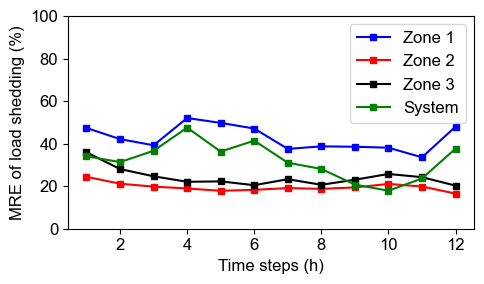

In [103]:
x = np.arange(1, 13)

fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(111)
ax.plot(x, shedding_mre[0], color='blue', marker='s', markersize=5, label='Zone 1')
ax.plot(x, shedding_mre[1], color='red', marker='s', markersize=5, label='Zone 2')
ax.plot(x, shedding_mre[2], color='black', marker='s', markersize=5, label='Zone 3')
ax.plot(x, shedding_mre[3], color='green', marker='s', markersize=5, label='System')
ax.set_xlabel('Time steps (h)')
ax.set_ylim((0, 100))
ax.set_ylabel('MRE of load shedding (%)')
ax.legend()

plt.tight_layout()
plt.show()
plt.close('all')

##### Calculate PF prediction

In [13]:
# Read PTDF matrix
file_path = f'../../data/IEEE_Case118/PTDF/PTDF_matrix.csv'
PTDF = pd.read_csv(file_path, header=None, index_col=None).to_numpy()

In [14]:
for i in range(num_data):
    # Read PG true
    file_path = f'./model_evaluation/PG_true/true_{i+1}.csv'
    PG_true = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    PB_true = PG_true[:, :nt] - PG_true[:, -nt:]
    PF_true = np.round(PTDF@PB_true, 2)
    file_path = f'../../src/IEEE_Case118/model_evaluation/PF_true/true_{i+1}.csv'
    pd.DataFrame(PF_true).to_csv(file_path, columns=None, index=None, header=None)

    # Read PG prediction
    file_path = f'./model_evaluation/PG_pred/pred_{i+1}.csv'
    PG_pred = pd.read_csv(file_path, header=None, index_col=None).to_numpy()
    PB_pred = PG_pred[:, :nt] - PG_pred[:, -nt:]
    PF_pred = np.round(PTDF@PB_pred, 2)
    file_path = f'../../src/IEEE_Case118/model_evaluation/PF_pred/pred_{i+1}.csv'
    pd.DataFrame(PF_pred).to_csv(file_path, columns=None, index=None, header=None)